In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/archive.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/train" # Directory containing the training data
test_dir = "/content/test"  # Directory containing the validation data



In [4]:
! pip install livelossplot

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [6]:
%load_ext tensorboard
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [7]:

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range=0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip=True,         # Flip images horizontally at random
    validation_split=0.2,         # Set aside 20% of the data for validation
    rescale=1./255                # Rescale pixel values to be between 0 and 1
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale pixel values to be between 0 and 1
    validation_split=0.2          # Set aside 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (224, 224),          # Resizes all images to 48x48 pixels
    batch_size = 256,                 # Number of images per batch      # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (224, 224),          # Resizes all images to 48x48 pixels
    batch_size = 256,                 # Number of images per batch      # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

import numpy as np
np.random.seed(1000)

#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                    

In [9]:
# Training parameters
EPOCHS = 5
BATCH_SIZE = 256

# Number of samples in your training and validation sets
train_num = train_generator.samples
valid_num = validation_generator.samples

# Fit the model
history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=train_num // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=valid_num // BATCH_SIZE,
    verbose=1
)


Epoch 1/5
89/89 [==============================] - 292s 3s/step - loss: 1.8876 - accuracy: 0.2377 - val_loss: 1.8163 - val_accuracy: 0.2484
Epoch 2/5
89/89 [==============================] - 261s 3s/step - loss: 1.8150 - accuracy: 0.2513 - val_loss: 1.8116 - val_accuracy: 0.2508
Epoch 3/5
89/89 [==============================] - 260s 3s/step - loss: 1.8130 - accuracy: 0.2514 - val_loss: 1.8150 - val_accuracy: 0.2461
Epoch 4/5
89/89 [==============================] - 262s 3s/step - loss: 1.8123 - accuracy: 0.2513 - val_loss: 1.8160 - val_accuracy: 0.2461
Epoch 5/5
89/89 [==============================] - 265s 3s/step - loss: 1.8133 - accuracy: 0.2513 - val_loss: 1.8167 - val_accuracy: 0.2453


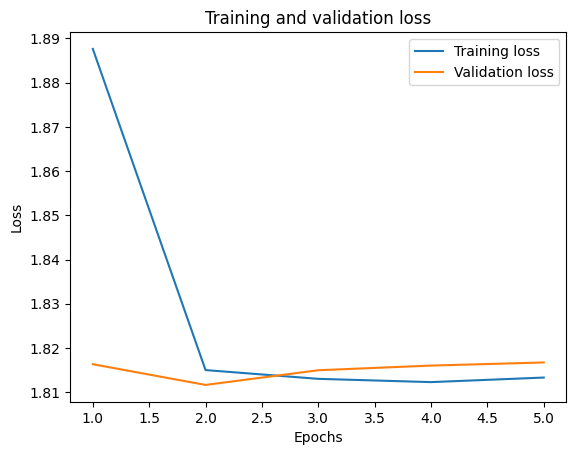

In [10]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

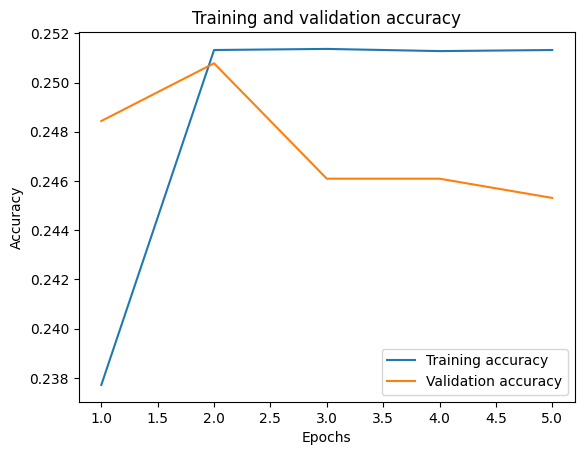

In [11]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 [==============================] - 4s 711ms/step


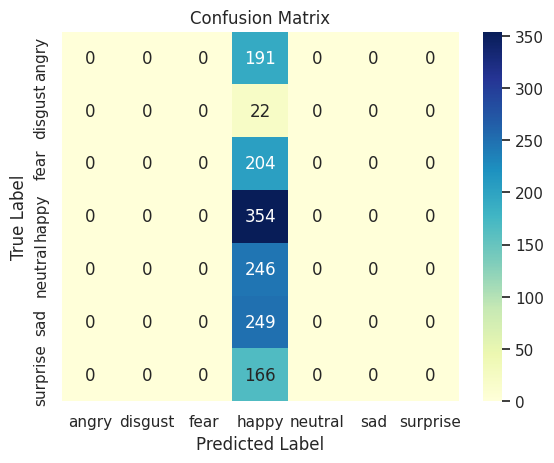

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()